<a href="https://colab.research.google.com/github/satrio-hw/crostonTSB_deepdive/blob/main/Intermittent_Demand_Forecasting_(Crosston_TSB).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demand Forcasting with Intermittent Dataset
## About
"Demand forecasting is a popular topic in industry, aimed at helping businesses make strategic decisions, particularly regarding procurement allocation. Traditionally, this has been done manually based on field observations. However, recently, machine learning approaches have gained prominence due to their superior performance in handling large volumes of data. Forecasting itself is a common problem to address using machine learning techniques.

The challenge lies in selecting the most suitable machine learning technique for a given dataset. The type of dataset is crucial, as machine learning methods often perform best with _"ideal"_ data conditions, which are rarely encountered in real-world scenarios. The conditions and assumptions made during data collection can significantly impact the _"ideality"_ of the data.

One common issue is intermittent data. By definition, intermittent data consists of demand history (typically found in transaction data) characterized by low variability in quantity but high variability in the time intervals between transactions. In other words, **_intermittent data occurs when the sales volume of a particular product is relatively stable, but the frequency of transactions for that product is highly sporadic._**

Direct forecasting using common machine learning approaches (such as XGBoost, ARIMA, etc.) may not be effective and may result in high errors. In such cases, the Croston's method can be implemented to address the challenges posed by intermittent datasets.

## Dataset Details
This project utilizes a synthetic dataset generated using the Python library `faker`. This dataset simulates real-life transaction data for 150 products categorized into three distinct groups: _"Electronics," "Hardware," and "Consumables"._

The dataset encompasses 5723 orders spanning the years 2022 to 2025 across nine different cities situated within four distinct regions: _"Java," "Sumatra," "Bali," and "Sulawesi"._

In [1]:
!pip install permetrics
import pandas as pd
file_path = '/content/drive/MyDrive/Colab Notebooks/assets/trx_dummy_mostly_intermittent.xlsx'
transaction_df = pd.read_excel(file_path)
display(transaction_df.sort_values(by='date'))

pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', None)
transaction_df.info()
transaction_df.describe()

,order_id,costumer_id,product_id,date,price,city,region,product_category,quantity,first_of_month
161,ORD-162,U-8,7-Hardware,2022-01-22,260.64,Bandung,Java,Hardware,7,2022-01-01
160,ORD-161,U-8,21-Hardware,2022-01-30,154.20,Makassar,Sulawesi,Hardware,5,2022-01-01
2208,ORD-2209,U-97,35-Electronics,2022-02-04,436.30,Yogyakarta,Java,Electronics,3,2022-02-01
1619,ORD-1620,U-71,43-Hardware,2022-02-04,206.78,Denpasar,Bali,Hardware,1,2022-02-01
137,ORD-138,U-7,30-Consumables,2022-02-05,33.38,Medan,Sumatra,Consumables,5,2022-02-01
...,...,...,...,...,...,...,...,...,...,...
4770,ORD-4771,U-210,16-Hardware,2024-12-29,77.09,Semarang,Java,Hardware,1,2024-12-01
5695,ORD-5696,U-250,43-Electronics,2024-12-29,43.65,Yogyakarta,Java,Electronics,3,2024-12-01
3838,ORD-3839,U-170,16-Consumables,2025-01-02,26.89,Palembang,Sumatra,Consumables,12,2025-01-01
4769,ORD-4770,U-210,17-Hardware,2025-01-06,302.90,Palembang,Sumatra,Hardware,3,2025-01-01


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5723 entries, 0 to 5722
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   order_id          5723 non-null   object        
 1   costumer_id       5723 non-null   object        
 2   product_id        5723 non-null   object        
 3   date              5723 non-null   datetime64[ns]
 4   price             5723 non-null   float64       
 5   city              5723 non-null   object        
 6   region            5723 non-null   object        
 7   product_category  5723 non-null   object        
 8   quantity          5723 non-null   int64         
 9   first_of_month    5723 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(6)
memory usage: 447.2+ KB


,date,price,quantity,first_of_month
count,5723,5723.000000,5723.000000,5723
mean,2023-07-12 13:49:34.733531648,256.995361,5.898829,2023-06-27 19:09:38.088415232
...,...,...,...,...
max,2025-01-07 00:00:00,499.900000,14.000000,2025-01-01 00:00:00
std,NaN,142.028545,3.476903,NaN


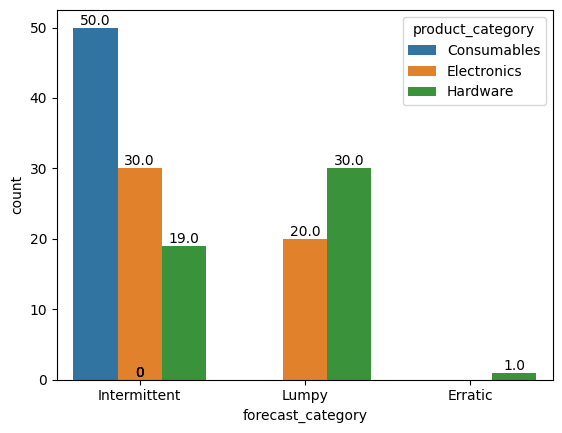

,product_id,cv2,adi,product_category,forecast_category
0,23-Consumables,0.314952,1.636364,Consumables,Intermittent
1,29-Electronics,0.462767,1.440000,Electronics,Intermittent
...,...,...,...,...,...
148,16-Electronics,0.501889,1.714286,Electronics,Lumpy
149,5-Hardware,0.547753,1.565217,Hardware,Lumpy


In [2]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
def avg_demand_interval(df, product_id):
  df_temp = df.copy()

  product_data = df_temp[df_temp['product_id'] == product_id].sort_values('date')
  demand_bucket = len(product_data['first_of_month'].unique())
  last_overall_order = df_temp['first_of_month'].max()
  first_order_prod = product_data['first_of_month'].min()
  period = ((pd.to_datetime(last_overall_order).year - pd.to_datetime(first_order_prod).year) * 12)
  + ( pd.to_datetime(last_overall_order).month - pd.to_datetime(first_order_prod).month)
  adi = period/demand_bucket
  return adi

def categorize_products(df):
  conditions = [
      (df['cv2'] < 0.49) & (df['adi'] < 1.32), # Smooth
      (df['cv2'] < 0.49) & (df['adi'] >= 1.32), # Intermittent
      (df['cv2'] >= 0.49) & (df['adi'] < 1.32), # Erratic
      (df['cv2'] >= 0.49) & (df['adi'] >= 1.32), # Lumpy
  ]

  choices = ['Smooth', 'Intermittent', 'Erratic', 'Lumpy']
  df['forecast_category'] = np.select(conditions, choices, default='Unknown') # use np.select
  return df

cv2_ls, prod_id_ls, adi_ls = [[] for i in range(3)]
for prod in transaction_df['product_id'].unique():
  temp = transaction_df.iloc[:][transaction_df['product_id']==prod]
  cv2_quantity = temp['quantity'].std() / temp['quantity'].mean()
  cv2_ls.append(cv2_quantity)
  prod_id_ls.append(prod)
  adi_ls.append(avg_demand_interval(transaction_df,prod))
product_forecastable_df = pd.DataFrame({'product_id':prod_id_ls,'cv2':cv2_ls, 'adi':adi_ls})
product_forecastable_df['product_category'] = product_forecastable_df['product_id'].str.split('-',expand=True)[1]
product_forecastable_df = categorize_products(product_forecastable_df)
sns.countplot(x='forecast_category', hue='product_category', data=product_forecastable_df)
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                   textcoords='offset points')
plt.show()
product_forecastable_df

The graph above visualizes the classification of products based on their demand patterns, using Average Demand Interval (ADI) and the squared Coefficient of Variation (CV²) as key metrics. Here's some details regarding the data:

* **Data Characteristics:**

  * **ADI:** Measures the average time between orders for a specific product. Higher ADI indicates less frequent orders.
  * **CV²:** Represents the squared coefficient of variation, measuring the variability of order quantities. Higher CV² suggests greater fluctuations in order sizes.

* **Classification:**

  * **Intermittent Data:** 60% of products fall into this category, characterized by infrequent orders (high ADI) but relatively stable order quantities (low CV²).
  * **Lumpy Data:** 33% of products exhibit both irregular order intervals and significant fluctuations in order quantities.
  * **Eratic Data:** 1% of products fall into this category, which have regular order but unstable order quantities.

The majority of orders of intermittent product originate from the "Java" region. Intermittent demand patterns pose unique challenges for traditional forecasting methods. **_Techniques like Croston's method are often more suitable for accurately predicting demand in such cases._**

,order_id,costumer_id,product_id,date,price,city,region,product_category,quantity,first_of_month,forecast_category
0,ORD-1,U-1,23-Consumables,2024-03-19,267.36,Yogyakarta,Java,Consumables,13,2024-03-01,Intermittent
1,ORD-2,U-1,29-Electronics,2024-01-31,15.57,Yogyakarta,Java,Electronics,3,2024-01-01,Intermittent
...,...,...,...,...,...,...,...,...,...,...,...
5721,ORD-5722,U-250,5-Consumables,2023-03-20,294.52,Jakarta,Java,Consumables,10,2023-03-01,Intermittent
5722,ORD-5723,U-250,14-Electronics,2023-02-27,413.31,Bandung,Java,Electronics,2,2023-02-01,Intermittent


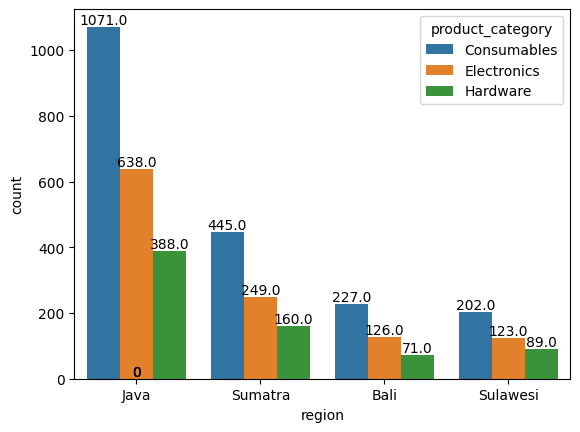

In [3]:
detail_trx_df = pd.merge(transaction_df, product_forecastable_df, on=['product_id','product_category'], how='left')
detail_trx_df = detail_trx_df.drop(columns=['cv2','adi'])
intermittent_df = detail_trx_df.iloc[:][detail_trx_df['forecast_category']=='Intermittent']
# sns.histplot(intermittent_df, x='region', hue='product_category')

sns.countplot(x='region', hue='product_category', data=intermittent_df)
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                   textcoords='offset points')
intermittent_df

## Forecasting (Croston TSB)
Croston TSB is one of the few methods that can be utilized to solve intermittent data problems. The principle behind Croston TSB involves implementing gradient smoothing using two different coefficients: alpha and beta.

These coefficients essentially correspond to the rise and/or fall of the forecasted value based on previous values. **_Alpha_** specifically corresponds to a level value, or the "absolute" forecasted demand, while **_beta_** corresponds to the probability of the forecasted demand value.

The final forecasted value is the multiplication of the probability and the level value, generated using the alpha and beta coefficients.

In [4]:
def Croston_TSB(ts, extra_periods=1, alpha=0.4, beta=0.4):
  d = np.array(ts) # Transform the input into a numpy array
  cols = len(d) # Historical period length
  d = np.append(d,[np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods
  a,p,f = np.full((3,cols+extra_periods),np.nan) #level (a), probability(p) and forecast (f)

  # Initialization
  first_occurence = np.argmax(d[:cols]>0)
  a[0] = d[first_occurence]
  p[0] = 1/(1 + first_occurence)
  f[0] = p[0]*a[0]

  # Create all the t+1 forecasts
  for t in range(0,cols):
      if d[t] > 0:
          a[t+1] = alpha*d[t] + (1-alpha)*a[t]
          p[t+1] = beta*(1) + (1-beta)*p[t]
      else:
          a[t+1] = a[t]
          p[t+1] = (1-beta)*p[t]
      f[t+1] = p[t+1]*a[t+1]

  # Future Forecast
  a[cols+1:cols+extra_periods] = a[cols]
  p[cols+1:cols+extra_periods] = p[cols]
  f[cols+1:cols+extra_periods] = f[cols]

  df = pd.DataFrame.from_dict({"demand":d,"forecast":f,"period":p,"level":a,"error":d-f})
  return df

def tsbcroston_forecast(df, alpha=0.5, beta=0.5):
  result_by_key_ls, timeseries_ls = [[] for i in range(2)]
  for key in (df.product_id.unique().tolist()):
    temp = df.iloc[:][df['product_id']==key].copy()
    for reg in temp.region.unique().tolist():
      temp_reg = temp.iloc[:][temp['region']==reg]
      df_order = temp_reg.groupby(by=['first_of_month','region']).sum('quantity').reset_index()

      df_ts = df_order.copy()
      df_ts.index = pd.DatetimeIndex(df_order['first_of_month'], dayfirst = True)
      df_ts = df_ts.sort_index()
      df_ts = df_ts.reindex(pd.date_range(df_ts.index.min(), df_ts.index.max(), freq='MS'), fill_value = 0)
      df_ts = df_ts.loc[df_ts[(df_ts != 0)].first_valid_index():].drop(['first_of_month'], axis=1)
      df_ts['product_id'] = key
      df_ts['first_of_month'] = df_ts.index
      df_ts['region'] = reg
      df_ts = df_ts.reset_index().drop(columns=['index','price'])
      df_ts = df_ts[['first_of_month','product_id','region','quantity']]
      ts = df_ts['quantity'].copy(deep = True)
      ts.index = df_ts['first_of_month']

      result = Croston_TSB(ts)
      df_ts['forecast_cont'] = result.iloc[:-1].forecast.tolist()
      df_ts['forecast_rounded'] = np.round(result.iloc[:-1].forecast.tolist())
      add_row = pd.DataFrame({
        'first_of_month':[df_ts.first_of_month.max() + pd.DateOffset(months=1)],
        'product_id':[df_ts.product_id.unique().item()],
        'region':[df_ts.region.unique().item()],
        'quantity':[None],
        'forecast_cont':[result.iloc[-1].forecast.item()],
        'forecast_rounded':[round(result.iloc[-1].forecast.item())]
       })
      df_ts = pd.concat([df_ts,add_row])
      result_by_key_ls.append(df_ts)
    result_by_key = pd.concat(result_by_key_ls)
  return result_by_key

result_by_key = tsbcroston_forecast(intermittent_df)
result_by_key

,first_of_month,product_id,region,quantity,forecast_cont,forecast_rounded
0,2022-04-01,23-Consumables,Java,11,11.000000,11.0
1,2022-05-01,23-Consumables,Java,0,11.000000,11.0
...,...,...,...,...,...,...
16,2024-03-01,26-Electronics,Sumatra,5,2.308298,2.0
0,2024-04-01,26-Electronics,Sumatra,None,3.348582,3.0


The results above show that the `quantity` column represents the actual demand, while the `forecast_cont` column represents the Croston TSB result. As we are trying to forecast demand for concrete products, the Croston TSB result values are rounded in the `forecast_rounded` column.

Product ID: 23-Consumables


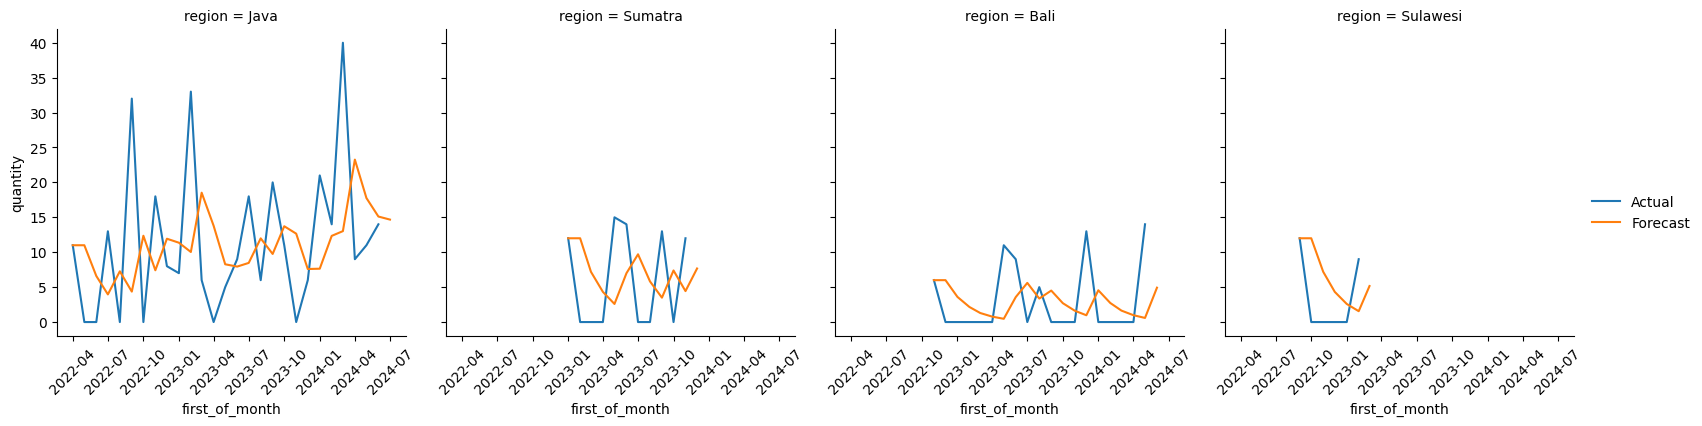

Product ID: 29-Electronics


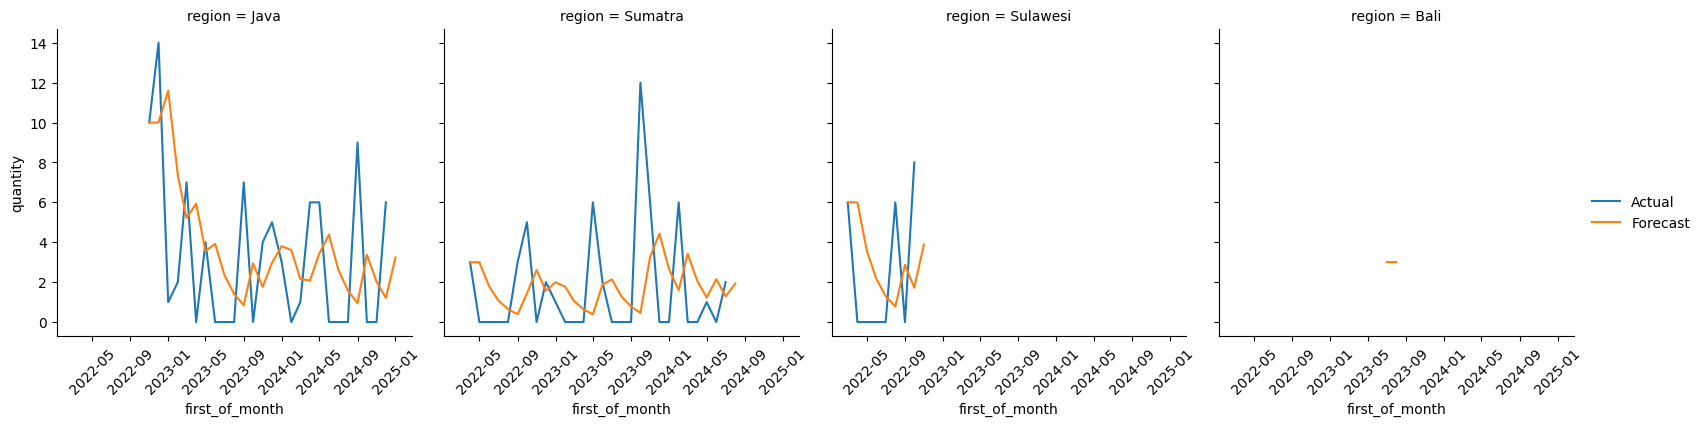

Product ID: 30-Electronics


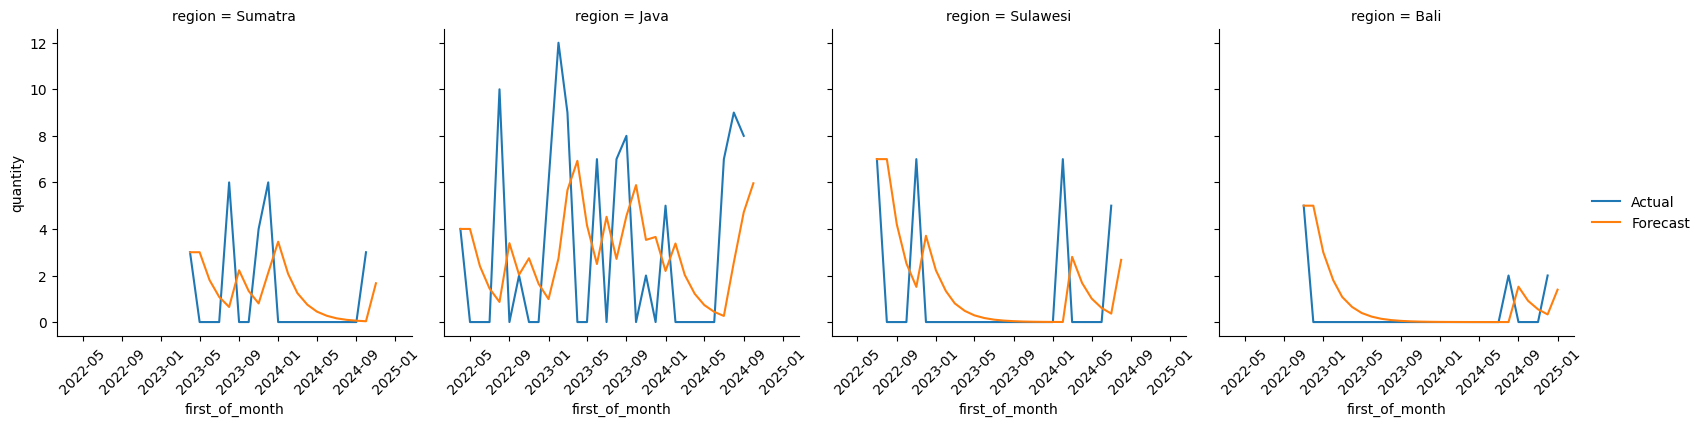

Product ID: 13-Consumables


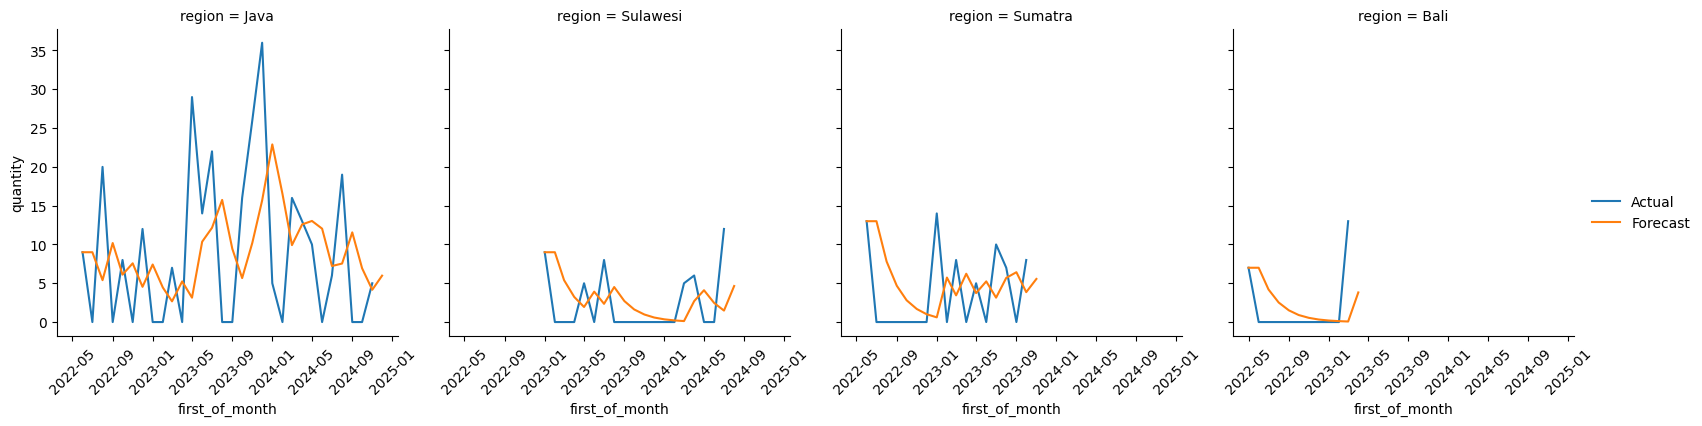

Product ID: 41-Electronics


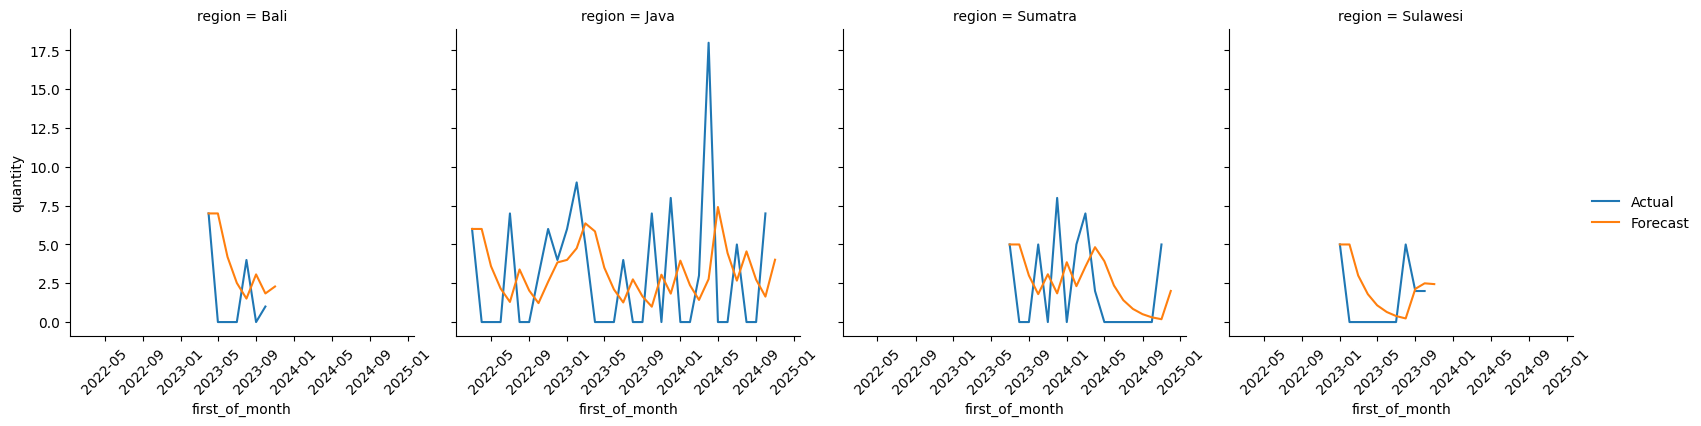

In [5]:
import warnings
warnings.filterwarnings("ignore")
i=0
for prod_id in result_by_key.product_id.unique().tolist():
  tmp_1 = result_by_key.iloc[:][result_by_key['product_id']==prod_id][['first_of_month','product_id','region','quantity']].copy()
  tmp_1['tag'] = 'Actual'
  tmp_2 = result_by_key.iloc[:][result_by_key['product_id']==prod_id][['first_of_month','product_id','region','forecast_cont']].copy()
  tmp_2 = tmp_2.rename(columns={'forecast_cont': 'quantity'})
  tmp_2['tag'] = 'Forecast'
  tmp = pd.concat([tmp_1,tmp_2])
  tmp = tmp.reset_index().drop(columns=['index'])
  print('Product ID: '+prod_id)
  g = sns.FacetGrid(tmp, col='region', height=4, aspect=1)
  g.map_dataframe(sns.lineplot, x='first_of_month', y='quantity', hue='tag')
  g.add_legend()
  for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)
  plt.show()
  i+=1
  if i==5:
    break;

If we try to simulate a sample of products, the graph above shows that the trend between Actual and Forecast is quite aligned, despite fluctuations. For some products, if the actual demand is 0, the forecast will be adjusted to near zero gradually (for example, product 30-Electronics)

## Model Evaluation
To evaluate the forecast, we could use 2 metrics. First is Mean Arctangent Absolute Precentage Error (MAAPE) and Cumulative Forecasting Error (CFE).

### MAAPE
The Mean Arctangent Absolute Percentage Error (MAAPE) is a metric used to calculate the error by comparing the actual values to the forecasted values, even when the actual value is zero. It keeps the error value relatively stable (around 157%) in cases where no actual demand is found.

The MAAPE value can rise to more than 100%, indicating that the difference between actual and forecast is so significant that it may be caused by different data assumptions or characteristics.

In [6]:
from permetrics.regression import RegressionMetric

prod_ls, region_ls, maape_ls, unforcastable_ls = [[] for i in range(4)]

for prod in result_by_key.product_id.unique().tolist():
  tmp = result_by_key.iloc[:][result_by_key['product_id']==prod].copy()
  for reg in tmp.region.unique().tolist():
    tmp_reg = tmp.iloc[:][(tmp['region']==reg)&(tmp['quantity']>=0)]
    if len(tmp_reg)<=2:
      unforcastable_ls.append(tmp_reg)
      pass;
    else:
      y_true = tmp_reg['quantity'].tolist()
      y_pred = tmp_reg['forecast_cont'].tolist()
      evaluator = RegressionMetric(y_true, y_pred)

      prod_ls.append(prod)
      region_ls.append(reg)
      maape_ls.append(evaluator.mean_arctangent_absolute_percentage_error())

maape_evaluation = pd.DataFrame({'product_id':prod_ls, 'region':region_ls, 'MAAPE':maape_ls})
pivot_maape_raw = maape_evaluation.pivot_table(index='region', columns='product_id', values='MAAPE')
pivot_maape = pivot_maape_raw.reset_index()

pivot_maape['avg_MAAPE'] = pivot_maape_raw.mean(axis=1).reset_index()[[0]]
display(pivot_maape)
unforcastable = pd.concat(unforcastable_ls)
pd.set_option('display.max_rows', None)
display(unforcastable.sort_values(by=['product_id', 'region']).reset_index().drop(columns='index'))
pd.set_option('display.max_rows', 5)

product_id,region,1-Consumables,10-Consumables,11-Consumables,12-Consumables,12-Electronics,13-Consumables,13-Hardware,14-Consumables,14-Electronics,14-Hardware,15-Consumables,15-Electronics,15-Hardware,16-Consumables,17-Consumables,17-Electronics,17-Hardware,18-Consumables,18-Electronics,19-Consumables,19-Electronics,2-Consumables,2-Hardware,20-Consumables,20-Hardware,21-Consumables,21-Electronics,21-Hardware,22-Consumables,22-Electronics,23-Consumables,23-Electronics,24-Consumables,24-Electronics,24-Hardware,25-Consumables,26-Consumables,26-Electronics,27-Consumables,27-Electronics,28-Consumables,28-Electronics,28-Hardware,29-Consumables,29-Electronics,3-Consumables,3-Hardware,30-Consumables,30-Electronics,31-Consumables,31-Electronics,31-Hardware,32-Consumables,32-Electronics,33-Consumables,33-Hardware,34-Consumables,34-Hardware,35-Consumables,35-Electronics,36-Consumables,36-Electronics,37-Consumables,37-Hardware,38-Consumables,38-Electronics,39-Consumables,39-Electronics,39-Hardware,4-Consumables,40-Consumables,40-Hardware,41-Consumables,41-Electronics,42-Consumables,42-Hardware,43-Consumables,43-Electronics,43-Hardware,44-Consumables,45-Consumables,46-Consumables,46-Electronics,47-Consumables,47-Electronics,48-Consumables,48-Electronics,49-Consumables,49-Electronics,5-Consumables,5-Electronics,50-Consumables,50-Electronics,6-Consumables,6-Hardware,7-Consumables,8-Consumables,9-Consumables,9-Electronics,avg_MAAPE
0,Bali,1.284918,1.334723,1.456872,1.303493,1.198227,1.356350,1.204462,1.306961,1.222567,1.345252,1.334366,1.371372,1.423526,1.269821,1.274910,1.318069,1.306818,1.140702,1.313465,1.237415,1.138605,1.213529,1.160605,1.325210,1.318158,1.232674,1.078339,1.110836,1.164078,1.170577,1.239621,1.272053,1.423503,1.404027,1.373233,1.404833,1.059871,1.125924,1.271518,1.356263,0.949533,1.392487,1.307739,1.326960,NaN,1.359136,1.367911,1.333849,1.446534,1.134332,1.432193,1.439628,1.452985,1.402495,1.276094,1.354059,1.308131,NaN,1.374214,1.244405,1.304805,1.002064,NaN,1.054419,1.301010,1.408938,1.245175,1.075459,1.437818,NaN,1.184782,1.457744,1.413651,1.077149,1.307788,1.371559,1.269720,1.249494,NaN,1.242291,1.343029,1.027229,1.228421,1.201796,1.034671,1.162055,NaN,NaN,1.406350,0.964599,NaN,1.266613,1.231762,0.851151,1.269875,1.371353,1.292117,1.406802,1.301111,1.269376
1,Java,1.055919,0.802266,0.814934,1.021359,0.989904,0.891907,1.087128,0.912000,0.889209,1.214385,0.921309,0.824980,1.071353,0.735636,0.824048,0.958761,1.146802,0.986205,1.136249,0.877163,0.998930,0.934894,1.095914,1.004812,1.116369,1.067310,0.923950,0.796874,0.814539,0.673471,0.736393,0.973226,1.149951,1.005804,0.795166,1.044477,1.001138,0.896287,0.785062,1.034179,1.045836,0.738131,0.942017,1.136171,0.989620,0.861276,1.064805,0.950996,1.068916,0.907583,1.162449,0.910260,0.928312,0.958511,0.847897,1.057003,0.896927,0.970635,0.878505,1.005269,0.865061,1.024625,0.878114,0.971308,0.859249,1.048265,1.017993,0.997838,1.040435,0.811419,0.979799,1.097704,0.898251,1.054611,1.009160,1.051663,0.928725,1.162503,0.898080,0.966437,0.929712,1.094933,0.981569,1.012042,0.815676,0.800513,0.956736,0.815426,1.076114,0.924830,0.903098,0.853672,0.835475,1.030242,0.800604,1.164353,0.964738,1.145405,0.910067,0.958665
2,Sulawesi,1.330249,0.818924,1.346841,1.235392,1.435880,1.241014,1.372844,1.439889,NaN,1.405425,0.866136,1.343830,1.240484,1.338825,1.350595,1.402184,1.303253,1.295092,1.389491,1.324782,1.463696,NaN,1.247748,NaN,1.293012,1.338817,1.336037,1.343192,1.158757,1.000034,1.162382,1.319225,1.258046,1.332685,1.166567,1.338745,NaN,1.289208,1.318288,1.282983,1.220221,1.253164,1.308330,1.239261,1.154467,1.338121,1.468353,1.325496,1.407382,1.383651,NaN,1.352130,NaN,1.308551,1.144904,0.773608,1.434096,1.345507,1.394208,1.366707,NaN,1.112271,1.364786,1.409091,0.576484,0.790131,1.255368,1.284921,1.004545,1.267755,1.327213,1.238576,NaN,1.049918,NaN,1.275433,NaN,1.323031,NaN,1.225988,1.300143,1.290581,1.389495,1.285425,1.298234,1.311225,1.346356,1.458595,NaN,1.246341,1.284571,NaN,1.238065,1

,first_of_month,product_id,region,quantity,forecast_cont,forecast_rounded
0,2024-06-01,2-Consumables,Sulawesi,10,10.0,10.0
1,2022-09-01,20-Consumables,Sulawesi,11,11.0,11.0
2,2024-01-01,26-Consumables,Sulawesi,10,10.0,10.0
3,2023-07-01,29-Electronics,Bali,3,3.0,3.0
4,2023-05-01,31-Electronics,Sulawesi,6,6.0,6.0
5,2023-03-01,32-Consumables,Sulawesi,6,6.0,6.0
6,2023-04-01,34-Hardware,Bali,4,4.0,4.0
7,2022-10-01,36-Consumables,Sulawesi,25,25.0,25.0
8,2022-07-01,37-Consumables,Bali,9,9.0,9.0
9,2023-06-01,4-Consumables,Bali,12,12.0,12.0


The table above shows that the MAAPE values for each region vary between approximately 95% and 120%, indicating that the difference between actual and forecasted values is relatively high.

We also identified 24 combinations of product and region that are unforecastable due to a lack of historical data.

### CFE
Sometimes, error and accuracy are not the most important metrics in demand forecasting. As the goal is to optimize the procurement process, it is also crucial to consider stock in model evaluation.

The CFE value provides a general picture of the product's stock condition at the end of the forecasting process, assuming the products are long-lasting. The assumptions underlying the CFE value are:


*   `CFE = 0` ; ideal condition, which all stocked product based on forecast are sold at the end.
*   `CFE > 0` ; indicates the underestimate model, describing the condition when the forecasted value < actual demand, which potentially leads to under-stock
*   `CFE < 0` ; indicates the overestimate model, describing the condition when the forecasted value > actual demand, which potentially leads to over-stock


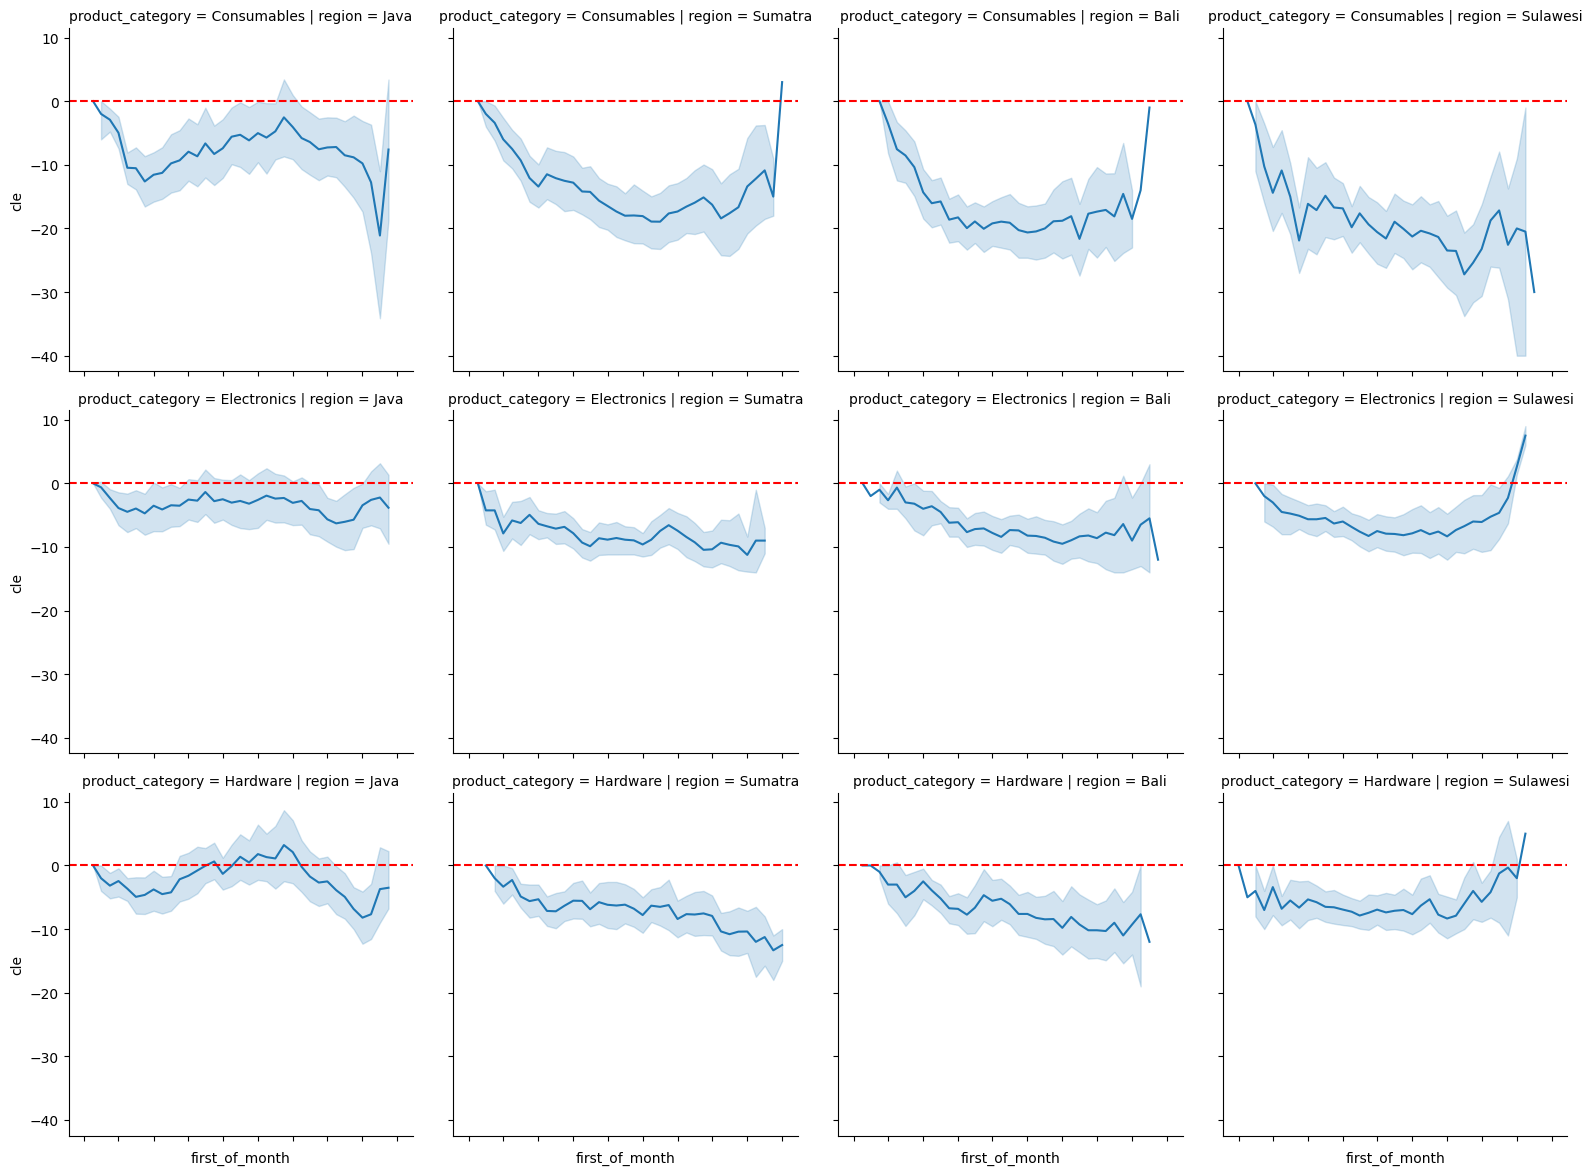

In [7]:
pd.set_option('display.max_rows', None)
cfe_ls = []

for prod in result_by_key.product_id.unique().tolist():
  tmp = result_by_key.iloc[:][result_by_key['product_id']==prod].copy()
  for reg in tmp.region.unique().tolist():
    tmp_reg = tmp.iloc[:][(tmp['region']==reg)&(tmp['quantity']>=0)]
    tmp_reg['forecast_error'] = tmp_reg['quantity'] - tmp_reg['forecast_rounded']
    tmp_reg['cle'] = tmp_reg['forecast_error'].cumsum()
    cfe_ls.append(tmp_reg)

cfe_df = pd.concat(cfe_ls)

cfe_df['product_category'] = cfe_df['product_id'].str.split('-',expand=True)[1]

g = sns.FacetGrid(cfe_df, col='region', row='product_category', height=4, aspect=1)
g.map_dataframe(sns.lineplot, x='first_of_month', y='cle')
for ax in g.axes.flat:
    ax.axhline(y=0, color='r', linestyle='--')
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)

In our results, the CFE values generally show values below zero, **indicating that the forecasts tend to overestimate demand.** This can lead to over-stocking problems unless we can identify products as fast-moving. This requires further analysis.

## Concussion
Forecasting intermittent demand is a challenging problem. However, the Croston TSB method effectively addresses this challenge, particularly in capturing the trend of actual demand.

However, Croston is inherently limited to one-period-ahead forecasts due to its mathematical foundation. This limitation makes the **Croston TSB model an unsuitable choice for long-term forecasting.**

The forecasting results indicate that the model tends to overestimate demand, although it exhibits relatively stable performance in Java due to the high volume of transactions in that region.